# DQN Extensions

In [ ]:
# This project aims in implementation of DQN extension such as DDQN, Duelling DDQN and Prioritized Replay Buffer
# for SpaceInvaders Environment from MinAtar package.

# Package Installation

In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

# Imports

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

# Model Network

In [2]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)

        self.linear = nn.Linear(32*6*6, 512)

        self.value = nn.Linear(512, 1)
        self.advantage = nn.Linear(512, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value


# Action Selection Policy

In [3]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

# Linear Decay for Hyperparameters - Epsilon, Alpha, Beta

In [4]:
def linear_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

# PrioritizedReplayBuffer

In [5]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size: int, obs_size):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.max_size = max_size
        #self.data = deque(maxlen=max_size)
        self.obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.act_rew_term = torch.zeros(size = (max_size,3))
        self.next_obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.priorities = torch.zeros(max_size)
        self.probabilities = torch.zeros(max_size)
        self.probabilities[0] = 1
        self.position = 0
        self.max = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def get_probabilities(self, alpha):
        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))
        # Priority could have approximation errors, so to address this we use alpha;
        # alpha=0.0 becomes Pure Random sampling
        # alpha=1.0 becomes Pure prioritized random sampling

        #print(priorities_tensor)
        scaled_priorities = torch.pow(self.priorities, alpha)
        if torch.sum(scaled_priorities) == 0:
            return torch.tensor([1])
        else:
           return scaled_priorities / torch.sum(scaled_priorities)

        #priorities_tensor.pow_(alpha)
        #return (priorities_tensor.div_(priorities_tensor.sum()))

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        # importance_weight = Corrects the bias introduced by not uniformly sampling during the neural network backward pass
        # importance_weight = ((1/N) * (1/Probability(i))) ^ Beta
        # Beta is a hyperparameter here; which similar to alpha, controls how much we want to prioritize

        N_length = max(self.max, self.position)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        #importance_weight_normalized = scaled_importance_weight / torch.max(scaled_importance_weight)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)
        #return scaled_importance_weight

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        #data = (obs, action, reward, next_obs, terminated)
        self.obs[self.position] = obs
        self.act_rew_term[self.position,:] = torch.tensor([action, reward, terminated])
        self.next_obs[self.position] = next_obs
        self.priorities[self.position] = max(self.priorities[0:self.position], default=1)
        if (self.position + 1) % self.max_size == 0:
            self.max = self.max_size
        self.position = (self.position + 1) % self.max_size
        #print(self.position)
        
        
    def update_probabilities(self, alpha):
        self.probabilities = self.get_probabilities(alpha)
    
    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        #sample_size = min(len(self.data), batch_size)
        
        #print(f'Probs: {self.probabilities[0:max(self.max, self.position)]}')
        indexer = range(0,max(self.max, self.position))
        #print(f'Priorities: {self.priorities[0:max(self.max, self.position)]}')
        sample_indices = torch.tensor(random.choices(indexer, k=batch_size, weights=self.probabilities[0:max(self.max, self.position)].tolist()))
        #print(f'Sample indices: {self.probabilities[0:max(self.max, self.position)].tolist()}')
        #print(f'Sample indices: {sample_indices}')
        #print(self.act_rew_term)
        selected_obs = self.obs[sample_indices]
        selected_nextobs = self.next_obs[sample_indices]
        act_rew_term = self.act_rew_term[sample_indices]
        importance = self.get_importance(self.probabilities[sample_indices], beta)
        return selected_obs, act_rew_term[:,0], act_rew_term[:,1], selected_nextobs, act_rew_term[:,2], sample_indices, importance

# Update Q Network

In [6]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.type(torch.int64).unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean()
    # Calculating weighted loss - considering errors of individual samples in loss
    weighted_loss = mseloss * importance_weights_mean

    weighted_loss.backward()
    optimizer.step()

    # Error is used to set the priority values for these experience
    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


# Agent Creation

In [7]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class Duelling_DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            buffer_hyperparam_eps_start = 1.0,
            buffer_hyperparam_eps_end = 0.1,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.buffer_param_start = buffer_hyperparam_eps_start
        self.buffer_param_end = buffer_hyperparam_eps_end

        self.buffer = PrioritizedReplayBuffer(maxlen, env.observation_space.shape)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 20 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            obs, _ = self.env.reset()

            for episode_time in itertools.count():

                epsilon = linear_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                alpha = linear_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)
                beta = linear_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)


                # Update the Q network
                batch_errors = update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)
                self.buffer.update_probabilities(alpha)

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

# Environment Creation

In [8]:
# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



# Setting Hyperparameter

In [9]:
# Hyperparameters
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 200 #100
DISCOUNT_FACTOR = 0.99

# Priority Scaling Hyperparameter
ALPHA = 1.0 #0.5
# Importance Sampling weight hyperparameter
BETA = 1.0 #0.5
# Decaying Hyperparamteres of Prioritizied Replay Buffer
# Decay of alpha and beta gives slightly better results compared to
# constant(1.0) alpha and beta value
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1

# Train Agent

In [14]:
# Train DQN
agent1 = Duelling_DDQNAgent(
    env,
    gamma=0.99,
    lr=0.001,
    batch_size=32,
    eps_start=0.5,
    eps_end=0.01,
    schedule_duration=10_000,
    update_freq=100,
    maxlen=100_000,
    alpha=1.0,
    beta=1.0,
    buffer_hyperparam_eps_start = 1.0,
    buffer_hyperparam_eps_end = 0.1,
)
stats1 = agent1.train(100)

# Train DQN
agent2 = Duelling_DDQNAgent(
    env,
    gamma=0.99,
    lr=0.001,
    batch_size=32,
    eps_start=0.5,
    eps_end=0.01,
    schedule_duration=10_000,
    update_freq=100,
    maxlen=100_000,
    alpha=1.0,
    beta=1.0,
    buffer_hyperparam_eps_start = 1.0,
    buffer_hyperparam_eps_end = 0.1,
)
stats2 = agent2.train(100)

# Train DQN
agent3 = Duelling_DDQNAgent(
    env,
    gamma=0.99,
    lr=0.001,
    batch_size=32,
    eps_start=0.7,
    eps_end=0.01,
    schedule_duration=10_000,
    update_freq=100,
    maxlen=100_000,
    alpha=1.0,
    beta=1.0,
    buffer_hyperparam_eps_start = 1.0,
    buffer_hyperparam_eps_end = 0.1,
)
stats3 = agent3.train(100)

# Train DQN
agent4 = Duelling_DDQNAgent(
    env,
    gamma=0.99,
    lr=0.001,
    batch_size=64,
    eps_start=0.5,
    eps_end=0.05,
    schedule_duration=10_000,
    update_freq=50,
    maxlen=100_000,
    alpha=1.0,
    beta=1.0,
    buffer_hyperparam_eps_start = 1.0,
    buffer_hyperparam_eps_end = 0.1,
)
stats4 = agent4.train(100)

# Train DQN
agent5 = Duelling_DDQNAgent(
    env,
    gamma=0.99,
    lr=0.005,
    batch_size=64,
    eps_start=0.7,
    eps_end=0.1,
    schedule_duration=10_000,
    update_freq=50,
    maxlen=100_000,
    alpha=1.0,
    beta=1.0,
    buffer_hyperparam_eps_start = 1.0,
    buffer_hyperparam_eps_end = 0.1,
)
stats5 = agent5.train(100)


Episode 20 of 100  Time Step: 1060  Epsilon: 0.448 Alpha: 0.905 Beta: 0.905
Episode 40 of 100  Time Step: 2176  Epsilon: 0.393 Alpha: 0.804 Beta: 0.804
Episode 60 of 100  Time Step: 4119  Epsilon: 0.298 Alpha: 0.629 Beta: 0.629
Episode 80 of 100  Time Step: 7550  Epsilon: 0.130 Alpha: 0.321 Beta: 0.321
Episode 100 of 100  Time Step: 9395  Epsilon: 0.040 Alpha: 0.155 Beta: 0.155
Episode 20 of 100  Time Step: 1055  Epsilon: 0.448 Alpha: 0.905 Beta: 0.905
Episode 40 of 100  Time Step: 2140  Epsilon: 0.395 Alpha: 0.807 Beta: 0.807
Episode 60 of 100  Time Step: 3326  Epsilon: 0.337 Alpha: 0.701 Beta: 0.701
Episode 80 of 100  Time Step: 4483  Epsilon: 0.280 Alpha: 0.597 Beta: 0.597
Episode 100 of 100  Time Step: 6360  Epsilon: 0.188 Alpha: 0.428 Beta: 0.428
Episode 20 of 100  Time Step: 1185  Epsilon: 0.618 Alpha: 0.893 Beta: 0.893
Episode 40 of 100  Time Step: 2015  Epsilon: 0.561 Alpha: 0.819 Beta: 0.819
Episode 60 of 100  Time Step: 3179  Epsilon: 0.481 Alpha: 0.714 Beta: 0.714
Episode 80

# Results

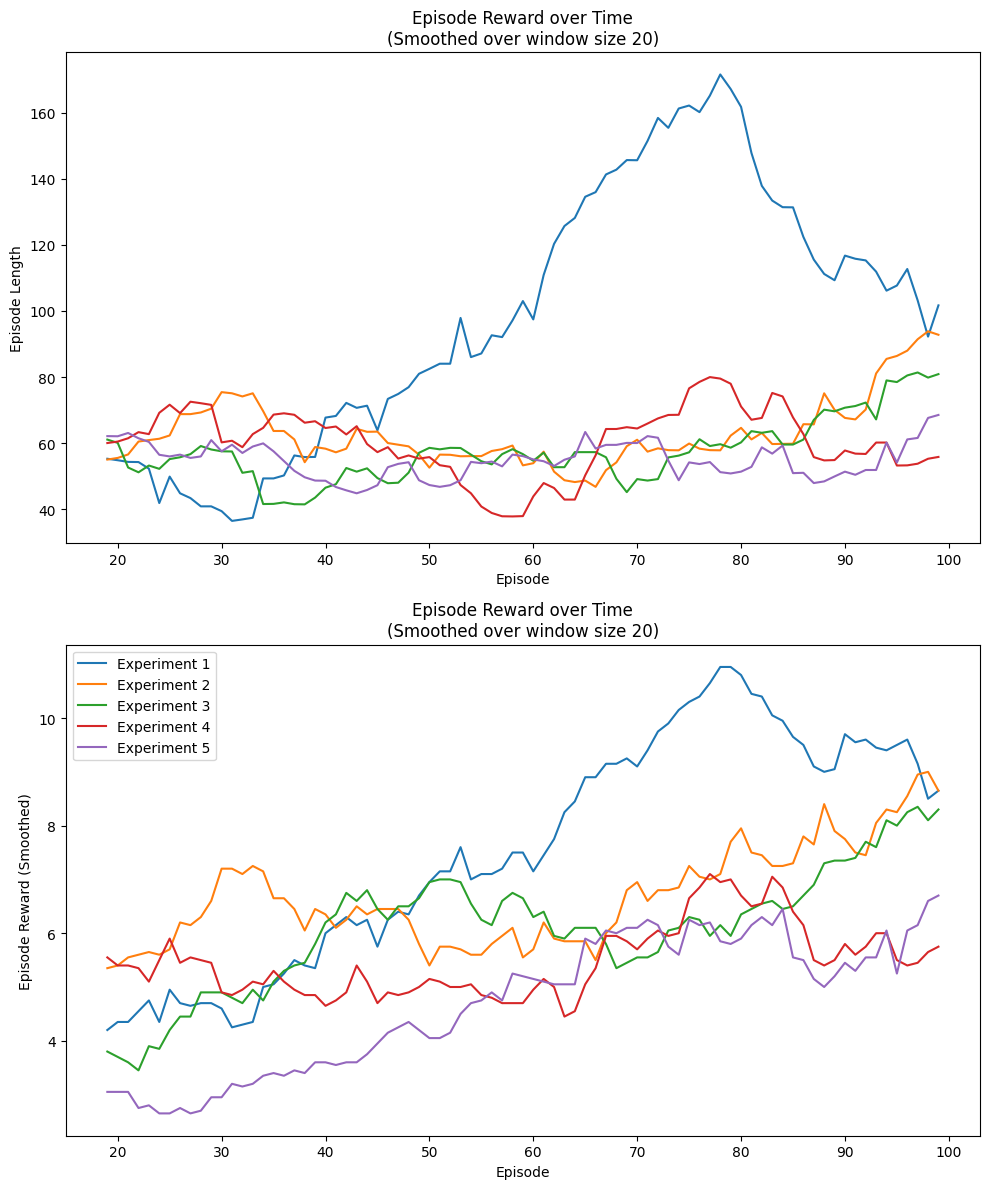

In [15]:
smoothing_window=20
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
lengths_smoothed1 = pd.Series(stats1.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed2 = pd.Series(stats2.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed3 = pd.Series(stats3.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed4 = pd.Series(stats4.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed5 = pd.Series(stats5.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(lengths_smoothed1, label = "Experiment 1")
ax.plot(lengths_smoothed2, label = "Experiment 2")
ax.plot(lengths_smoothed3, label = "Experiment 3")
ax.plot(lengths_smoothed4, label = "Experiment 4")
ax.plot(lengths_smoothed5, label = "Experiment 5")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed1 = pd.Series(stats1.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed2 = pd.Series(stats2.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed3 = pd.Series(stats3.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed4 = pd.Series(stats4.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed5 = pd.Series(stats5.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed1, label = "Experiment 1")
ax.plot(rewards_smoothed2, label = "Experiment 2")
ax.plot(rewards_smoothed3, label = "Experiment 3")
ax.plot(rewards_smoothed4, label = "Experiment 4")
ax.plot(rewards_smoothed5, label = "Experiment 5")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.legend()
plt.show()